In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os
DIR_INPUT_IMAGES='/Users/skulkarni9/Desktop/face-mask-detection/archive/images/'
DIR_INPUT_ANNOTATION='/Users/skulkarni9/Desktop/face-mask-detection/archive/annotations/'

In [2]:

def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target


In [3]:
imgs = list(sorted(os.listdir(DIR_INPUT_IMAGES)))

In [4]:
labels = list(sorted(os.listdir(DIR_INPUT_ANNOTATION)))

In [5]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(DIR_INPUT_IMAGES)))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join(DIR_INPUT_IMAGES, file_image)
        label_path = os.path.join(DIR_INPUT_ANNOTATION, file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [8]:
torch.cuda.is_available()

False

# Model

In [9]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    return torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

In [10]:
model = get_model_instance_segmentation(3)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]]), 'labels': tensor([0, 1, 0]), 'image_id': tensor([0])}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0]), 'image_id': tensor([1])}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]]), 'labels': tensor([1, 1, 1, 2]), 'image_id': tensor([2])}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
        [112.,  51., 120.,  68.],
        [155.,  60., 177.,  83.],
        [189.,  59., 210.,  80.],
        [235.,  57., 257.,  78.],
        [289.,  60.

# Train Model

In [12]:
num_epochs = 20
# num_epochs = 1
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        print(f'Epoch: {epoch}, Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)


/Users/skulkarni9/Desktop/face-mask-detection/venv/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 0, Iteration: 1/214, Loss: 3.3914713859558105
Epoch: 0, Iteration: 2/214, Loss: 1.155541181564331
Epoch: 0, Iteration: 3/214, Loss: 1.1560155153274536
Epoch: 0, Iteration: 4/214, Loss: 1.2891652584075928
Epoch: 0, Iteration: 5/214, Loss: 1.2247381210327148
Epoch: 0, Iteration: 6/214, Loss: 0.8985138535499573
Epoch: 0, Iteration: 7/214, Loss: 2.202479362487793
Epoch: 0, Iteration: 8/214, Loss: 0.9253808259963989
Epoch: 0, Iteration: 9/214, Loss: 1.089010238647461
Epoch: 0, Iteration: 10/214, Loss: 1.0971403121948242
Epoch: 0, Iteration: 11/214, Loss: 0.9021626710891724
Epoch: 0, Iteration: 12/214, Loss: 1.0679044723510742
Epoch: 0, Iteration: 13/214, Loss: 1.9175045490264893
Epoch: 0, Iteration: 14/214, Loss: 1.606414556503296
Epoch: 0, Iteration: 15/214, Loss: 0.9560009241104126
Epoch: 0, Iteration: 16/214, Loss: 0.756596565246582
Epoch: 0, Iteration: 17/214, Loss: 2.680008888244629
Epoch: 0, Iteration: 18/214, Loss: 1.3577375411987305
Epoch: 0, Iteration: 19/214, Loss: 1.593806

Epoch: 0, Iteration: 153/214, Loss: 0.4361647069454193
Epoch: 0, Iteration: 154/214, Loss: 0.6330350637435913
Epoch: 0, Iteration: 155/214, Loss: 1.1577107906341553
Epoch: 0, Iteration: 156/214, Loss: 0.7052080035209656
Epoch: 0, Iteration: 157/214, Loss: 0.7417805194854736
Epoch: 0, Iteration: 158/214, Loss: 0.48173797130584717
Epoch: 0, Iteration: 159/214, Loss: 0.8289114236831665
Epoch: 0, Iteration: 160/214, Loss: 0.935401439666748
Epoch: 0, Iteration: 161/214, Loss: 0.5820615291595459
Epoch: 0, Iteration: 162/214, Loss: 0.41652077436447144
Epoch: 0, Iteration: 163/214, Loss: 0.43060579895973206
Epoch: 0, Iteration: 164/214, Loss: 0.26584815979003906
Epoch: 0, Iteration: 165/214, Loss: 0.6113553047180176
Epoch: 0, Iteration: 166/214, Loss: 0.7291581034660339
Epoch: 0, Iteration: 167/214, Loss: 0.7207236289978027
Epoch: 0, Iteration: 168/214, Loss: 0.5511672496795654
Epoch: 0, Iteration: 169/214, Loss: 0.8553521037101746
Epoch: 0, Iteration: 170/214, Loss: 0.6859691143035889
Epoch: 

Epoch: 1, Iteration: 89/214, Loss: 0.5015069246292114
Epoch: 1, Iteration: 90/214, Loss: 0.23427295684814453
Epoch: 1, Iteration: 91/214, Loss: 0.1472453773021698
Epoch: 1, Iteration: 92/214, Loss: 0.22412565350532532
Epoch: 1, Iteration: 93/214, Loss: 0.3187237083911896
Epoch: 1, Iteration: 94/214, Loss: 0.163209930062294
Epoch: 1, Iteration: 95/214, Loss: 0.43701690435409546
Epoch: 1, Iteration: 96/214, Loss: 0.23143130540847778
Epoch: 1, Iteration: 97/214, Loss: 0.25614699721336365
Epoch: 1, Iteration: 98/214, Loss: 0.6000354290008545
Epoch: 1, Iteration: 99/214, Loss: 0.6188302636146545
Epoch: 1, Iteration: 100/214, Loss: 0.32789480686187744
Epoch: 1, Iteration: 101/214, Loss: 0.44087833166122437
Epoch: 1, Iteration: 102/214, Loss: 0.5942496061325073
Epoch: 1, Iteration: 103/214, Loss: 0.4932035207748413
Epoch: 1, Iteration: 104/214, Loss: 2.0395848751068115
Epoch: 1, Iteration: 105/214, Loss: 0.407778263092041
Epoch: 1, Iteration: 106/214, Loss: 0.46264466643333435
Epoch: 1, Itera

Epoch: 2, Iteration: 24/214, Loss: 0.4684112071990967
Epoch: 2, Iteration: 25/214, Loss: 0.2396407276391983
Epoch: 2, Iteration: 26/214, Loss: 0.4171571731567383
Epoch: 2, Iteration: 27/214, Loss: 0.5528905391693115
Epoch: 2, Iteration: 28/214, Loss: 0.297369122505188
Epoch: 2, Iteration: 29/214, Loss: 0.4846349358558655
Epoch: 2, Iteration: 30/214, Loss: 0.27668917179107666
Epoch: 2, Iteration: 31/214, Loss: 0.2262255996465683
Epoch: 2, Iteration: 32/214, Loss: 0.413420706987381
Epoch: 2, Iteration: 33/214, Loss: 0.37871330976486206
Epoch: 2, Iteration: 34/214, Loss: 0.6085203886032104
Epoch: 2, Iteration: 35/214, Loss: 0.19898360967636108
Epoch: 2, Iteration: 36/214, Loss: 0.2726513147354126
Epoch: 2, Iteration: 37/214, Loss: 0.2847871482372284
Epoch: 2, Iteration: 38/214, Loss: 0.5858431458473206
Epoch: 2, Iteration: 39/214, Loss: 0.2804400324821472
Epoch: 2, Iteration: 40/214, Loss: 0.6645435690879822
Epoch: 2, Iteration: 41/214, Loss: 0.2828918695449829
Epoch: 2, Iteration: 42/214

Epoch: 2, Iteration: 174/214, Loss: 0.20054619014263153
Epoch: 2, Iteration: 175/214, Loss: 0.38579946756362915
Epoch: 2, Iteration: 176/214, Loss: 0.1149420440196991
Epoch: 2, Iteration: 177/214, Loss: 0.22722385823726654
Epoch: 2, Iteration: 178/214, Loss: 0.339998334646225
Epoch: 2, Iteration: 179/214, Loss: 0.11858271062374115
Epoch: 2, Iteration: 180/214, Loss: 0.1822541356086731
Epoch: 2, Iteration: 181/214, Loss: 0.32592520117759705
Epoch: 2, Iteration: 182/214, Loss: 0.0942024439573288
Epoch: 2, Iteration: 183/214, Loss: 0.3572410047054291
Epoch: 2, Iteration: 184/214, Loss: 0.33043837547302246
Epoch: 2, Iteration: 185/214, Loss: 0.19535966217517853
Epoch: 2, Iteration: 186/214, Loss: 0.13395942747592926
Epoch: 2, Iteration: 187/214, Loss: 0.21392706036567688
Epoch: 2, Iteration: 188/214, Loss: 0.8661019206047058
Epoch: 2, Iteration: 189/214, Loss: 0.37026113271713257
Epoch: 2, Iteration: 190/214, Loss: 0.37018221616744995
Epoch: 2, Iteration: 191/214, Loss: 1.406891107559204
E

Epoch: 3, Iteration: 109/214, Loss: 0.22927123308181763
Epoch: 3, Iteration: 110/214, Loss: 0.19607709348201752
Epoch: 3, Iteration: 111/214, Loss: 0.4413297772407532
Epoch: 3, Iteration: 112/214, Loss: 0.35640978813171387
Epoch: 3, Iteration: 113/214, Loss: 0.17076140642166138
Epoch: 3, Iteration: 114/214, Loss: 0.1732165366411209
Epoch: 3, Iteration: 115/214, Loss: 0.08992451429367065
Epoch: 3, Iteration: 116/214, Loss: 0.3666131794452667
Epoch: 3, Iteration: 117/214, Loss: 0.15423718094825745
Epoch: 3, Iteration: 118/214, Loss: 0.1351761519908905
Epoch: 3, Iteration: 119/214, Loss: 0.13597798347473145
Epoch: 3, Iteration: 120/214, Loss: 0.243373304605484
Epoch: 3, Iteration: 121/214, Loss: 0.10282623767852783
Epoch: 3, Iteration: 122/214, Loss: 0.5485620498657227
Epoch: 3, Iteration: 123/214, Loss: 0.11402244120836258
Epoch: 3, Iteration: 124/214, Loss: 0.09032709151506424
Epoch: 3, Iteration: 125/214, Loss: 0.4158332943916321
Epoch: 3, Iteration: 126/214, Loss: 0.11536587029695511


Epoch: 4, Iteration: 43/214, Loss: 0.39667588472366333
Epoch: 4, Iteration: 44/214, Loss: 0.19499635696411133
Epoch: 4, Iteration: 45/214, Loss: 0.3402637243270874
Epoch: 4, Iteration: 46/214, Loss: 0.14966227114200592
Epoch: 4, Iteration: 47/214, Loss: 0.3575984537601471
Epoch: 4, Iteration: 48/214, Loss: 0.13465622067451477
Epoch: 4, Iteration: 49/214, Loss: 0.12476278096437454
Epoch: 4, Iteration: 50/214, Loss: 0.1568290889263153
Epoch: 4, Iteration: 51/214, Loss: 0.18264591693878174
Epoch: 4, Iteration: 52/214, Loss: 0.2197050005197525
Epoch: 4, Iteration: 53/214, Loss: 0.19236499071121216
Epoch: 4, Iteration: 54/214, Loss: 0.16439567506313324
Epoch: 4, Iteration: 55/214, Loss: 0.35354629158973694
Epoch: 4, Iteration: 56/214, Loss: 0.1574792116880417
Epoch: 4, Iteration: 57/214, Loss: 0.10626181960105896
Epoch: 4, Iteration: 58/214, Loss: 0.16298258304595947
Epoch: 4, Iteration: 59/214, Loss: 0.24871224164962769
Epoch: 4, Iteration: 60/214, Loss: 0.14489904046058655
Epoch: 4, Itera

Epoch: 4, Iteration: 192/214, Loss: 0.1680339276790619
Epoch: 4, Iteration: 193/214, Loss: 0.24801526963710785
Epoch: 4, Iteration: 194/214, Loss: 0.5072790384292603
Epoch: 4, Iteration: 195/214, Loss: 0.1540112942457199
Epoch: 4, Iteration: 196/214, Loss: 0.4479182958602905
Epoch: 4, Iteration: 197/214, Loss: 0.1858617663383484
Epoch: 4, Iteration: 198/214, Loss: 0.20371165871620178
Epoch: 4, Iteration: 199/214, Loss: 0.44713932275772095
Epoch: 4, Iteration: 200/214, Loss: 0.22122426331043243
Epoch: 4, Iteration: 201/214, Loss: 0.17920376360416412
Epoch: 4, Iteration: 202/214, Loss: 0.22147104144096375
Epoch: 4, Iteration: 203/214, Loss: 0.08306478708982468
Epoch: 4, Iteration: 204/214, Loss: 0.1381727159023285
Epoch: 4, Iteration: 205/214, Loss: 0.1715472936630249
Epoch: 4, Iteration: 206/214, Loss: 0.1287330687046051
Epoch: 4, Iteration: 207/214, Loss: 0.4323579668998718
Epoch: 4, Iteration: 208/214, Loss: 0.1365363746881485
Epoch: 4, Iteration: 209/214, Loss: 0.6023311614990234
Epo

Epoch: 5, Iteration: 127/214, Loss: 0.12858259677886963
Epoch: 5, Iteration: 128/214, Loss: 0.261510968208313
Epoch: 5, Iteration: 129/214, Loss: 0.2809390425682068
Epoch: 5, Iteration: 130/214, Loss: 0.2354709506034851
Epoch: 5, Iteration: 131/214, Loss: 0.32442089915275574
Epoch: 5, Iteration: 132/214, Loss: 0.2326621115207672
Epoch: 5, Iteration: 133/214, Loss: 0.23070284724235535
Epoch: 5, Iteration: 134/214, Loss: 0.10331466794013977
Epoch: 5, Iteration: 135/214, Loss: 0.14042390882968903
Epoch: 5, Iteration: 136/214, Loss: 0.16862650215625763
Epoch: 5, Iteration: 137/214, Loss: 0.13300718367099762
Epoch: 5, Iteration: 138/214, Loss: 0.2425079345703125
Epoch: 5, Iteration: 139/214, Loss: 0.2088860124349594
Epoch: 5, Iteration: 140/214, Loss: 0.4621480405330658
Epoch: 5, Iteration: 141/214, Loss: 0.1740158349275589
Epoch: 5, Iteration: 142/214, Loss: 0.5238643884658813
Epoch: 5, Iteration: 143/214, Loss: 0.1316167265176773
Epoch: 5, Iteration: 144/214, Loss: 0.24810296297073364
Epo

Epoch: 6, Iteration: 61/214, Loss: 0.4367660880088806
Epoch: 6, Iteration: 62/214, Loss: 0.217168390750885
Epoch: 6, Iteration: 63/214, Loss: 0.20931746065616608
Epoch: 6, Iteration: 64/214, Loss: 0.12186680734157562
Epoch: 6, Iteration: 65/214, Loss: 0.1961050182580948
Epoch: 6, Iteration: 66/214, Loss: 0.27411067485809326
Epoch: 6, Iteration: 67/214, Loss: 0.1984291970729828
Epoch: 6, Iteration: 68/214, Loss: 0.2514325976371765
Epoch: 6, Iteration: 69/214, Loss: 0.3640606999397278
Epoch: 6, Iteration: 70/214, Loss: 0.2982562780380249
Epoch: 6, Iteration: 71/214, Loss: 0.23540744185447693
Epoch: 6, Iteration: 72/214, Loss: 0.10163253545761108
Epoch: 6, Iteration: 73/214, Loss: 0.20306941866874695
Epoch: 6, Iteration: 74/214, Loss: 0.1459343433380127
Epoch: 6, Iteration: 75/214, Loss: 0.27353423833847046
Epoch: 6, Iteration: 76/214, Loss: 0.09269439429044724
Epoch: 6, Iteration: 77/214, Loss: 0.08444152027368546
Epoch: 6, Iteration: 78/214, Loss: 0.12298900634050369
Epoch: 6, Iteration

Epoch: 6, Iteration: 209/214, Loss: 0.2447110116481781
Epoch: 6, Iteration: 210/214, Loss: 0.15161843597888947
Epoch: 6, Iteration: 211/214, Loss: 0.08095012605190277
Epoch: 6, Iteration: 212/214, Loss: 0.12499910593032837
Epoch: 6, Iteration: 213/214, Loss: 0.16399641335010529
Epoch: 6, Iteration: 214/214, Loss: 0.17431271076202393
tensor(40.9931, grad_fn=<AddBackward0>)
Epoch: 7, Iteration: 1/214, Loss: 0.14924952387809753
Epoch: 7, Iteration: 2/214, Loss: 0.10912469774484634
Epoch: 7, Iteration: 3/214, Loss: 0.10753755271434784
Epoch: 7, Iteration: 4/214, Loss: 0.20241135358810425
Epoch: 7, Iteration: 5/214, Loss: 0.09322136640548706
Epoch: 7, Iteration: 6/214, Loss: 0.05603589862585068
Epoch: 7, Iteration: 7/214, Loss: 0.2391228973865509
Epoch: 7, Iteration: 8/214, Loss: 0.07702011615037918
Epoch: 7, Iteration: 9/214, Loss: 0.16938358545303345
Epoch: 7, Iteration: 10/214, Loss: 0.19755128026008606
Epoch: 7, Iteration: 11/214, Loss: 0.12636564671993256
Epoch: 7, Iteration: 12/214, L

Epoch: 7, Iteration: 144/214, Loss: 0.16890683770179749
Epoch: 7, Iteration: 145/214, Loss: 0.09462849795818329
Epoch: 7, Iteration: 146/214, Loss: 0.07939916104078293
Epoch: 7, Iteration: 147/214, Loss: 0.1752980500459671
Epoch: 7, Iteration: 148/214, Loss: 0.13564911484718323
Epoch: 7, Iteration: 149/214, Loss: 0.07263784110546112
Epoch: 7, Iteration: 150/214, Loss: 0.11848466843366623
Epoch: 7, Iteration: 151/214, Loss: 0.09160163998603821
Epoch: 7, Iteration: 152/214, Loss: 0.1002463772892952
Epoch: 7, Iteration: 153/214, Loss: 0.12369199842214584
Epoch: 7, Iteration: 154/214, Loss: 0.07033096998929977
Epoch: 7, Iteration: 155/214, Loss: 0.3035942316055298
Epoch: 7, Iteration: 156/214, Loss: 0.28247278928756714
Epoch: 7, Iteration: 157/214, Loss: 0.0711832344532013
Epoch: 7, Iteration: 158/214, Loss: 0.10973840951919556
Epoch: 7, Iteration: 159/214, Loss: 0.10970009118318558
Epoch: 7, Iteration: 160/214, Loss: 0.14625580608844757
Epoch: 7, Iteration: 161/214, Loss: 0.29117169976234

Epoch: 8, Iteration: 79/214, Loss: 0.1285085529088974
Epoch: 8, Iteration: 80/214, Loss: 0.10062611103057861
Epoch: 8, Iteration: 81/214, Loss: 0.10164076089859009
Epoch: 8, Iteration: 82/214, Loss: 0.08709464967250824
Epoch: 8, Iteration: 83/214, Loss: 0.04845385253429413
Epoch: 8, Iteration: 84/214, Loss: 0.07468259334564209
Epoch: 8, Iteration: 85/214, Loss: 0.15306009352207184
Epoch: 8, Iteration: 86/214, Loss: 0.10585860908031464
Epoch: 8, Iteration: 87/214, Loss: 0.12278735637664795
Epoch: 8, Iteration: 88/214, Loss: 0.12504953145980835
Epoch: 8, Iteration: 89/214, Loss: 0.09649741649627686
Epoch: 8, Iteration: 90/214, Loss: 0.12662431597709656
Epoch: 8, Iteration: 91/214, Loss: 0.08582863211631775
Epoch: 8, Iteration: 92/214, Loss: 0.10066968947649002
Epoch: 8, Iteration: 93/214, Loss: 0.167420893907547
Epoch: 8, Iteration: 94/214, Loss: 0.09413982927799225
Epoch: 8, Iteration: 95/214, Loss: 0.18942834436893463
Epoch: 8, Iteration: 96/214, Loss: 0.10812273621559143
Epoch: 8, Ite

Epoch: 9, Iteration: 13/214, Loss: 0.10999713838100433
Epoch: 9, Iteration: 14/214, Loss: 0.4286314845085144
Epoch: 9, Iteration: 15/214, Loss: 0.1379597783088684
Epoch: 9, Iteration: 16/214, Loss: 0.08732679486274719
Epoch: 9, Iteration: 17/214, Loss: 1.377197265625
Epoch: 9, Iteration: 18/214, Loss: 0.09929996728897095
Epoch: 9, Iteration: 19/214, Loss: 0.088950015604496
Epoch: 9, Iteration: 20/214, Loss: 0.15045779943466187
Epoch: 9, Iteration: 21/214, Loss: 0.07710662484169006
Epoch: 9, Iteration: 22/214, Loss: 0.09434467554092407
Epoch: 9, Iteration: 23/214, Loss: 0.05760002136230469
Epoch: 9, Iteration: 24/214, Loss: 0.17735449969768524
Epoch: 9, Iteration: 25/214, Loss: 0.12990382313728333
Epoch: 9, Iteration: 26/214, Loss: 0.08292088657617569
Epoch: 9, Iteration: 27/214, Loss: 0.1596699357032776
Epoch: 9, Iteration: 28/214, Loss: 0.133220836520195
Epoch: 9, Iteration: 29/214, Loss: 0.11620043218135834
Epoch: 9, Iteration: 30/214, Loss: 0.1623324304819107
Epoch: 9, Iteration: 31

Epoch: 9, Iteration: 162/214, Loss: 0.11312704533338547
Epoch: 9, Iteration: 163/214, Loss: 0.15068252384662628
Epoch: 9, Iteration: 164/214, Loss: 0.0770873948931694
Epoch: 9, Iteration: 165/214, Loss: 0.23689600825309753
Epoch: 9, Iteration: 166/214, Loss: 0.08367593586444855
Epoch: 9, Iteration: 167/214, Loss: 0.0692753791809082
Epoch: 9, Iteration: 168/214, Loss: 0.09576240926980972
Epoch: 9, Iteration: 169/214, Loss: 0.14912265539169312
Epoch: 9, Iteration: 170/214, Loss: 0.12924684584140778
Epoch: 9, Iteration: 171/214, Loss: 0.2029617428779602
Epoch: 9, Iteration: 172/214, Loss: 0.13002203404903412
Epoch: 9, Iteration: 173/214, Loss: 0.11170937120914459
Epoch: 9, Iteration: 174/214, Loss: 0.12279176712036133
Epoch: 9, Iteration: 175/214, Loss: 0.168460413813591
Epoch: 9, Iteration: 176/214, Loss: 0.11103390902280807
Epoch: 9, Iteration: 177/214, Loss: 0.12520214915275574
Epoch: 9, Iteration: 178/214, Loss: 0.11641643941402435
Epoch: 9, Iteration: 179/214, Loss: 0.059546969830989

Epoch: 10, Iteration: 95/214, Loss: 0.17077919840812683
Epoch: 10, Iteration: 96/214, Loss: 0.11399302631616592
Epoch: 10, Iteration: 97/214, Loss: 0.12779515981674194
Epoch: 10, Iteration: 98/214, Loss: 0.18482862412929535
Epoch: 10, Iteration: 99/214, Loss: 0.06635602563619614
Epoch: 10, Iteration: 100/214, Loss: 0.11673296242952347
Epoch: 10, Iteration: 101/214, Loss: 0.07355159521102905
Epoch: 10, Iteration: 102/214, Loss: 0.10289669781923294
Epoch: 10, Iteration: 103/214, Loss: 0.18001562356948853
Epoch: 10, Iteration: 104/214, Loss: 0.07435474544763565
Epoch: 10, Iteration: 105/214, Loss: 0.12071089446544647
Epoch: 10, Iteration: 106/214, Loss: 0.11641877889633179
Epoch: 10, Iteration: 107/214, Loss: 0.25628334283828735
Epoch: 10, Iteration: 108/214, Loss: 0.17676882445812225
Epoch: 10, Iteration: 109/214, Loss: 0.07373043894767761
Epoch: 10, Iteration: 110/214, Loss: 0.05789557099342346
Epoch: 10, Iteration: 111/214, Loss: 0.15012526512145996
Epoch: 10, Iteration: 112/214, Loss:

Epoch: 11, Iteration: 26/214, Loss: 0.12977655231952667
Epoch: 11, Iteration: 27/214, Loss: 0.15129272639751434
Epoch: 11, Iteration: 28/214, Loss: 0.09908173233270645
Epoch: 11, Iteration: 29/214, Loss: 0.08417120575904846
Epoch: 11, Iteration: 30/214, Loss: 0.13685265183448792
Epoch: 11, Iteration: 31/214, Loss: 0.1145809218287468
Epoch: 11, Iteration: 32/214, Loss: 0.1505148559808731
Epoch: 11, Iteration: 33/214, Loss: 0.12089736759662628
Epoch: 11, Iteration: 34/214, Loss: 0.13734321296215057
Epoch: 11, Iteration: 35/214, Loss: 0.05865859612822533
Epoch: 11, Iteration: 36/214, Loss: 0.11450092494487762
Epoch: 11, Iteration: 37/214, Loss: 0.12387797981500626
Epoch: 11, Iteration: 38/214, Loss: 0.18007226288318634
Epoch: 11, Iteration: 39/214, Loss: 0.16301825642585754
Epoch: 11, Iteration: 40/214, Loss: 0.29192012548446655
Epoch: 11, Iteration: 41/214, Loss: 0.10747314244508743
Epoch: 11, Iteration: 42/214, Loss: 0.13826040923595428
Epoch: 11, Iteration: 43/214, Loss: 0.147628158330

Epoch: 11, Iteration: 172/214, Loss: 0.12955263257026672
Epoch: 11, Iteration: 173/214, Loss: 0.1367834061384201
Epoch: 11, Iteration: 174/214, Loss: 0.07922124862670898
Epoch: 11, Iteration: 175/214, Loss: 0.1470400094985962
Epoch: 11, Iteration: 176/214, Loss: 0.09785023331642151
Epoch: 11, Iteration: 177/214, Loss: 0.11518599092960358
Epoch: 11, Iteration: 178/214, Loss: 0.09306593984365463
Epoch: 11, Iteration: 179/214, Loss: 0.0792890340089798
Epoch: 11, Iteration: 180/214, Loss: 0.07041449844837189
Epoch: 11, Iteration: 181/214, Loss: 0.10921859741210938
Epoch: 11, Iteration: 182/214, Loss: 0.043354522436857224
Epoch: 11, Iteration: 183/214, Loss: 0.13562220335006714
Epoch: 11, Iteration: 184/214, Loss: 0.1733563393354416
Epoch: 11, Iteration: 185/214, Loss: 0.1313815861940384
Epoch: 11, Iteration: 186/214, Loss: 0.14955279231071472
Epoch: 11, Iteration: 187/214, Loss: 0.1221851035952568
Epoch: 11, Iteration: 188/214, Loss: 0.08741720765829086
Epoch: 11, Iteration: 189/214, Loss:

Epoch: 12, Iteration: 104/214, Loss: 0.08440210670232773
Epoch: 12, Iteration: 105/214, Loss: 0.11473248898983002
Epoch: 12, Iteration: 106/214, Loss: 0.07661578059196472
Epoch: 12, Iteration: 107/214, Loss: 0.2548735737800598
Epoch: 12, Iteration: 108/214, Loss: 0.21183185279369354
Epoch: 12, Iteration: 109/214, Loss: 0.08811438083648682
Epoch: 12, Iteration: 110/214, Loss: 0.08533935248851776
Epoch: 12, Iteration: 111/214, Loss: 0.1370527446269989
Epoch: 12, Iteration: 112/214, Loss: 0.14116400480270386
Epoch: 12, Iteration: 113/214, Loss: 0.10119224339723587
Epoch: 12, Iteration: 114/214, Loss: 0.10210570693016052
Epoch: 12, Iteration: 115/214, Loss: 0.07028007507324219
Epoch: 12, Iteration: 116/214, Loss: 0.17747431993484497
Epoch: 12, Iteration: 117/214, Loss: 0.10532619804143906
Epoch: 12, Iteration: 118/214, Loss: 0.07561951130628586
Epoch: 12, Iteration: 119/214, Loss: 0.13935907185077667
Epoch: 12, Iteration: 120/214, Loss: 0.12000609934329987
Epoch: 12, Iteration: 121/214, Lo

Epoch: 13, Iteration: 35/214, Loss: 0.08953899145126343
Epoch: 13, Iteration: 36/214, Loss: 0.09897381067276001
Epoch: 13, Iteration: 37/214, Loss: 0.1315174549818039
Epoch: 13, Iteration: 38/214, Loss: 0.15572169423103333
Epoch: 13, Iteration: 39/214, Loss: 0.1695079207420349
Epoch: 13, Iteration: 40/214, Loss: 0.18377700448036194
Epoch: 13, Iteration: 41/214, Loss: 0.12956131994724274
Epoch: 13, Iteration: 42/214, Loss: 0.1421799659729004
Epoch: 13, Iteration: 43/214, Loss: 0.13574795424938202
Epoch: 13, Iteration: 44/214, Loss: 0.08278417587280273
Epoch: 13, Iteration: 45/214, Loss: 0.17845891416072845
Epoch: 13, Iteration: 46/214, Loss: 0.11475902795791626
Epoch: 13, Iteration: 47/214, Loss: 0.1165403500199318
Epoch: 13, Iteration: 48/214, Loss: 0.08375321328639984
Epoch: 13, Iteration: 49/214, Loss: 0.12283366173505783
Epoch: 13, Iteration: 50/214, Loss: 0.08836020529270172
Epoch: 13, Iteration: 51/214, Loss: 0.11214416474103928
Epoch: 13, Iteration: 52/214, Loss: 0.11465274542570

Epoch: 13, Iteration: 181/214, Loss: 0.08547745645046234
Epoch: 13, Iteration: 182/214, Loss: 0.06551758944988251
Epoch: 13, Iteration: 183/214, Loss: 0.13572661578655243
Epoch: 13, Iteration: 184/214, Loss: 0.12427344918251038
Epoch: 13, Iteration: 185/214, Loss: 0.0999617949128151
Epoch: 13, Iteration: 186/214, Loss: 0.05250931903719902
Epoch: 13, Iteration: 187/214, Loss: 0.09372350573539734
Epoch: 13, Iteration: 188/214, Loss: 0.09373612701892853
Epoch: 13, Iteration: 189/214, Loss: 0.19710326194763184
Epoch: 13, Iteration: 190/214, Loss: 0.1509661078453064
Epoch: 13, Iteration: 191/214, Loss: 0.14787136018276215
Epoch: 13, Iteration: 192/214, Loss: 0.13077473640441895
Epoch: 13, Iteration: 193/214, Loss: 0.12098314613103867
Epoch: 13, Iteration: 194/214, Loss: 0.13160136342048645
Epoch: 13, Iteration: 195/214, Loss: 0.10549389570951462
Epoch: 13, Iteration: 196/214, Loss: 0.15249228477478027
Epoch: 13, Iteration: 197/214, Loss: 0.11561060696840286
Epoch: 13, Iteration: 198/214, Lo

Epoch: 14, Iteration: 113/214, Loss: 0.1204395592212677
Epoch: 14, Iteration: 114/214, Loss: 0.10038544982671738
Epoch: 14, Iteration: 115/214, Loss: 0.08166837692260742
Epoch: 14, Iteration: 116/214, Loss: 0.1532292664051056
Epoch: 14, Iteration: 117/214, Loss: 0.1134541779756546
Epoch: 14, Iteration: 118/214, Loss: 0.07911377400159836
Epoch: 14, Iteration: 119/214, Loss: 0.12584474682807922
Epoch: 14, Iteration: 120/214, Loss: 0.14598090946674347
Epoch: 14, Iteration: 121/214, Loss: 0.07077540457248688
Epoch: 14, Iteration: 122/214, Loss: 0.08344559371471405
Epoch: 14, Iteration: 123/214, Loss: 0.14033767580986023
Epoch: 14, Iteration: 124/214, Loss: 0.11275555938482285
Epoch: 14, Iteration: 125/214, Loss: 0.0796351432800293
Epoch: 14, Iteration: 126/214, Loss: 0.05680455267429352
Epoch: 14, Iteration: 127/214, Loss: 0.07031276822090149
Epoch: 14, Iteration: 128/214, Loss: 0.1328345239162445
Epoch: 14, Iteration: 129/214, Loss: 0.1301427036523819
Epoch: 14, Iteration: 130/214, Loss: 

Epoch: 15, Iteration: 44/214, Loss: 0.08984364569187164
Epoch: 15, Iteration: 45/214, Loss: 0.1417614072561264
Epoch: 15, Iteration: 46/214, Loss: 0.07744190841913223
Epoch: 15, Iteration: 47/214, Loss: 0.14375965297222137
Epoch: 15, Iteration: 48/214, Loss: 0.058786675333976746
Epoch: 15, Iteration: 49/214, Loss: 0.06150557100772858
Epoch: 15, Iteration: 50/214, Loss: 0.06169678270816803
Epoch: 15, Iteration: 51/214, Loss: 0.07213909924030304
Epoch: 15, Iteration: 52/214, Loss: 0.10110700875520706
Epoch: 15, Iteration: 53/214, Loss: 0.05861834064126015
Epoch: 15, Iteration: 54/214, Loss: 0.04223944991827011
Epoch: 15, Iteration: 55/214, Loss: 0.0755060613155365
Epoch: 15, Iteration: 56/214, Loss: 0.06281094253063202
Epoch: 15, Iteration: 57/214, Loss: 0.0814647227525711
Epoch: 15, Iteration: 58/214, Loss: 0.03228360414505005
Epoch: 15, Iteration: 59/214, Loss: 0.12008630484342575
Epoch: 15, Iteration: 60/214, Loss: 0.038164738565683365
Epoch: 15, Iteration: 61/214, Loss: 0.19770307838

Epoch: 15, Iteration: 190/214, Loss: 0.12542879581451416
Epoch: 15, Iteration: 191/214, Loss: 0.1362026333808899
Epoch: 15, Iteration: 192/214, Loss: 0.15690185129642487
Epoch: 15, Iteration: 193/214, Loss: 0.10730863362550735
Epoch: 15, Iteration: 194/214, Loss: 0.12398984283208847
Epoch: 15, Iteration: 195/214, Loss: 0.10580690950155258
Epoch: 15, Iteration: 196/214, Loss: 0.13999754190444946
Epoch: 15, Iteration: 197/214, Loss: 0.15110595524311066
Epoch: 15, Iteration: 198/214, Loss: 0.09673593193292618
Epoch: 15, Iteration: 199/214, Loss: 0.12711529433727264
Epoch: 15, Iteration: 200/214, Loss: 0.12962748110294342
Epoch: 15, Iteration: 201/214, Loss: 0.10858162492513657
Epoch: 15, Iteration: 202/214, Loss: 0.12350830435752869
Epoch: 15, Iteration: 203/214, Loss: 0.06852113455533981
Epoch: 15, Iteration: 204/214, Loss: 0.10089148581027985
Epoch: 15, Iteration: 205/214, Loss: 0.10591930150985718
Epoch: 15, Iteration: 206/214, Loss: 0.07833796739578247
Epoch: 15, Iteration: 207/214, L

Epoch: 16, Iteration: 122/214, Loss: 0.10874343663454056
Epoch: 16, Iteration: 123/214, Loss: 0.1463346630334854
Epoch: 16, Iteration: 124/214, Loss: 0.12650692462921143
Epoch: 16, Iteration: 125/214, Loss: 0.08019337058067322
Epoch: 16, Iteration: 126/214, Loss: 0.06314706057310104
Epoch: 16, Iteration: 127/214, Loss: 0.07238169759511948
Epoch: 16, Iteration: 128/214, Loss: 0.1285526603460312
Epoch: 16, Iteration: 129/214, Loss: 0.12474137544631958
Epoch: 16, Iteration: 130/214, Loss: 0.10661064833402634
Epoch: 16, Iteration: 131/214, Loss: 0.10968827456235886
Epoch: 16, Iteration: 132/214, Loss: 0.1463218778371811
Epoch: 16, Iteration: 133/214, Loss: 0.1276334524154663
Epoch: 16, Iteration: 134/214, Loss: 0.11285194754600525
Epoch: 16, Iteration: 135/214, Loss: 0.1632358431816101
Epoch: 16, Iteration: 136/214, Loss: 0.0962061733007431
Epoch: 16, Iteration: 137/214, Loss: 0.09194837510585785
Epoch: 16, Iteration: 138/214, Loss: 0.073419950902462
Epoch: 16, Iteration: 139/214, Loss: 0.

Epoch: 17, Iteration: 53/214, Loss: 0.09761853516101837
Epoch: 17, Iteration: 54/214, Loss: 0.08447469770908356
Epoch: 17, Iteration: 55/214, Loss: 0.11631758511066437
Epoch: 17, Iteration: 56/214, Loss: 0.04326438158750534
Epoch: 17, Iteration: 57/214, Loss: 0.09845272451639175
Epoch: 17, Iteration: 58/214, Loss: 0.10771865397691727
Epoch: 17, Iteration: 59/214, Loss: 0.13311776518821716
Epoch: 17, Iteration: 60/214, Loss: 0.14421595633029938
Epoch: 17, Iteration: 61/214, Loss: 0.26728731393814087
Epoch: 17, Iteration: 62/214, Loss: 0.12971709668636322
Epoch: 17, Iteration: 63/214, Loss: 0.0967603251338005
Epoch: 17, Iteration: 64/214, Loss: 0.1144406720995903
Epoch: 17, Iteration: 65/214, Loss: 0.11451595276594162
Epoch: 17, Iteration: 66/214, Loss: 0.20247700810432434
Epoch: 17, Iteration: 67/214, Loss: 0.13147073984146118
Epoch: 17, Iteration: 68/214, Loss: 0.14296530187129974
Epoch: 17, Iteration: 69/214, Loss: 0.10120094567537308
Epoch: 17, Iteration: 70/214, Loss: 0.133171528577

Epoch: 17, Iteration: 198/214, Loss: 0.12512090802192688
Epoch: 17, Iteration: 199/214, Loss: 0.1319042593240738
Epoch: 17, Iteration: 200/214, Loss: 0.13254182040691376
Epoch: 17, Iteration: 201/214, Loss: 0.08892067521810532
Epoch: 17, Iteration: 202/214, Loss: 0.1407802700996399
Epoch: 17, Iteration: 203/214, Loss: 0.03651420399546623
Epoch: 17, Iteration: 204/214, Loss: 0.11940393596887589
Epoch: 17, Iteration: 205/214, Loss: 0.09208090603351593
Epoch: 17, Iteration: 206/214, Loss: 0.05251758173108101
Epoch: 17, Iteration: 207/214, Loss: 0.16895261406898499
Epoch: 17, Iteration: 208/214, Loss: 0.11480949074029922
Epoch: 17, Iteration: 209/214, Loss: 0.09433776140213013
Epoch: 17, Iteration: 210/214, Loss: 0.10760217905044556
Epoch: 17, Iteration: 211/214, Loss: 0.0717410072684288
Epoch: 17, Iteration: 212/214, Loss: 0.0946093276143074
Epoch: 17, Iteration: 213/214, Loss: 0.13018564879894257
Epoch: 17, Iteration: 214/214, Loss: 0.08612015098333359
tensor(23.5866, grad_fn=<AddBackwar

Epoch: 18, Iteration: 130/214, Loss: 0.08645379543304443
Epoch: 18, Iteration: 131/214, Loss: 0.07215914875268936
Epoch: 18, Iteration: 132/214, Loss: 0.10719282180070877
Epoch: 18, Iteration: 133/214, Loss: 0.09375840425491333
Epoch: 18, Iteration: 134/214, Loss: 0.05503314360976219
Epoch: 18, Iteration: 135/214, Loss: 0.08407854288816452
Epoch: 18, Iteration: 136/214, Loss: 0.0824236199259758
Epoch: 18, Iteration: 137/214, Loss: 0.06189006567001343
Epoch: 18, Iteration: 138/214, Loss: 0.08138018101453781
Epoch: 18, Iteration: 139/214, Loss: 0.055120907723903656
Epoch: 18, Iteration: 140/214, Loss: 0.09501093626022339
Epoch: 18, Iteration: 141/214, Loss: 0.05658638849854469
Epoch: 18, Iteration: 142/214, Loss: 0.15050122141838074
Epoch: 18, Iteration: 143/214, Loss: 0.08503595739603043
Epoch: 18, Iteration: 144/214, Loss: 0.10248390585184097
Epoch: 18, Iteration: 145/214, Loss: 0.06948495656251907
Epoch: 18, Iteration: 146/214, Loss: 0.06512098014354706
Epoch: 18, Iteration: 147/214, 

Epoch: 19, Iteration: 61/214, Loss: 0.18765774369239807
Epoch: 19, Iteration: 62/214, Loss: 0.10819562524557114
Epoch: 19, Iteration: 63/214, Loss: 0.1140054315328598
Epoch: 19, Iteration: 64/214, Loss: 0.08149242401123047
Epoch: 19, Iteration: 65/214, Loss: 0.11463335156440735
Epoch: 19, Iteration: 66/214, Loss: 0.1846310943365097
Epoch: 19, Iteration: 67/214, Loss: 0.13294990360736847
Epoch: 19, Iteration: 68/214, Loss: 0.10184555500745773
Epoch: 19, Iteration: 69/214, Loss: 0.11065776646137238
Epoch: 19, Iteration: 70/214, Loss: 0.09161553531885147
Epoch: 19, Iteration: 71/214, Loss: 0.12928593158721924
Epoch: 19, Iteration: 72/214, Loss: 0.07689513266086578
Epoch: 19, Iteration: 73/214, Loss: 0.08454969525337219
Epoch: 19, Iteration: 74/214, Loss: 0.07082686573266983
Epoch: 19, Iteration: 75/214, Loss: 0.16328604519367218
Epoch: 19, Iteration: 76/214, Loss: 0.07187923043966293
Epoch: 19, Iteration: 77/214, Loss: 0.09096812456846237
Epoch: 19, Iteration: 78/214, Loss: 0.103781990706

Epoch: 19, Iteration: 206/214, Loss: 0.06734256446361542
Epoch: 19, Iteration: 207/214, Loss: 0.1694726049900055
Epoch: 19, Iteration: 208/214, Loss: 0.065694659948349
Epoch: 19, Iteration: 209/214, Loss: 0.06068742647767067
Epoch: 19, Iteration: 210/214, Loss: 0.13238607347011566
Epoch: 19, Iteration: 211/214, Loss: 0.11708365380764008
Epoch: 19, Iteration: 212/214, Loss: 0.06626922637224197
Epoch: 19, Iteration: 213/214, Loss: 0.11060989648103714
Epoch: 19, Iteration: 214/214, Loss: 0.09322146326303482
tensor(22.5383, grad_fn=<AddBackward0>)


In [13]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [14]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[325.0222,  89.3927, 360.7635, 142.0039],
          [ 79.0368, 105.8097, 108.5814, 141.5216],
          [ 79.4413,  94.7839, 126.7531, 141.0719],
          [332.0250,  88.1059, 380.4489, 144.5649],
          [183.3064,  99.3102, 225.3772, 145.1777],
          [325.4915,  92.6355, 363.6674, 141.8594],
          [281.1693,  65.7078, 503.7110, 323.6844]], grad_fn=<StackBackward>),
  'scores': tensor([0.9992, 0.9975, 0.0654, 0.0530, 0.9999, 0.0878, 0.0540],
         grad_fn=<CatBackward>),
  'labels': tensor([0, 0, 0, 0, 1, 2, 2])},
 {'boxes': tensor([[ 81.1940,  53.7896, 112.0073,  88.5374],
          [150.1984,  41.5409, 179.9970,  64.5346],
          [318.7878,  32.2502, 351.9048,  70.0371],
          [ 84.7444,  65.2883, 109.1402,  86.2994],
          [ 93.0455,  58.2887, 112.4893,  85.2418],
          [366.7003,  69.5447, 398.1831,  97.3553],
          [109.3131,  55.8552, 115.6713,  69.6128],
          [317.8191,  32.8245, 353.8512,  71.7533],
          [221.6892, 

# Function to plot image

In [15]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Prediction


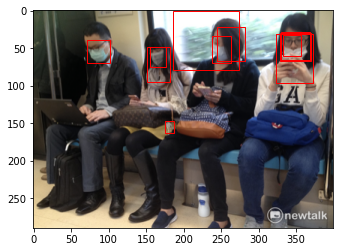

Target


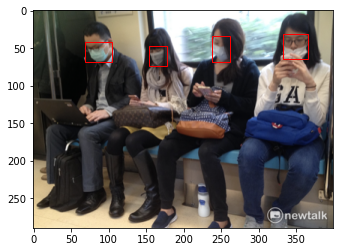

In [16]:
print("Prediction")
plot_image(imgs[2], preds[2])
print("Target")
plot_image(imgs[2], annotations[2])

In [17]:
torch.save(model.state_dict(),'retinanet.pt')

In [18]:
model2 = get_model_instance_segmentation(3)

# Save Model

In [19]:
model2.load_state_dict(torch.load('retinanet.pt'))
model2.eval()
model2.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256)
          )
        )
        (1): Bottleneck

# Load Model

In [20]:
pred2 = model2(imgs)

Predict with loaded model


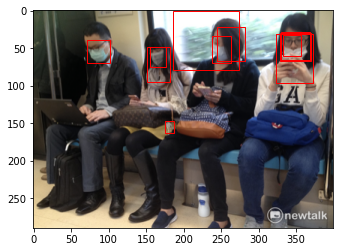

Target


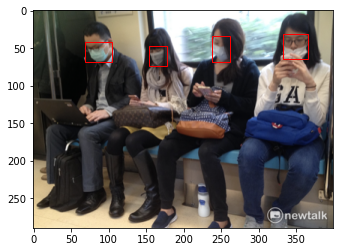

In [21]:
print("Predict with loaded model")
plot_image(imgs[2], preds[2])
print("Target")
plot_image(imgs[2], annotations[2])